## Augment the images using Albumentations library

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import albumentations as alb
import numpy as np
import cv2
import json
from pathlib import Path

In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

# GPU should be printed out if available like this ['/device:CPU:0']
print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    # Enable memory growth to avoid OOMs
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
IMAGES_DIR = os.path.join('..', 'data', 'images')
LABELS_DIR = os.path.join('..', 'data', 'labels')

In [5]:
image_pattern = os.path.join(IMAGES_DIR, '*.png')
images = [os.path.basename(file) for file in glob.glob(image_pattern)]

print(f'Amount of images in the dataset {len(images)}')

Amount of images in the dataset 960


In [6]:
import random

plot_images = random.sample(images, 10)

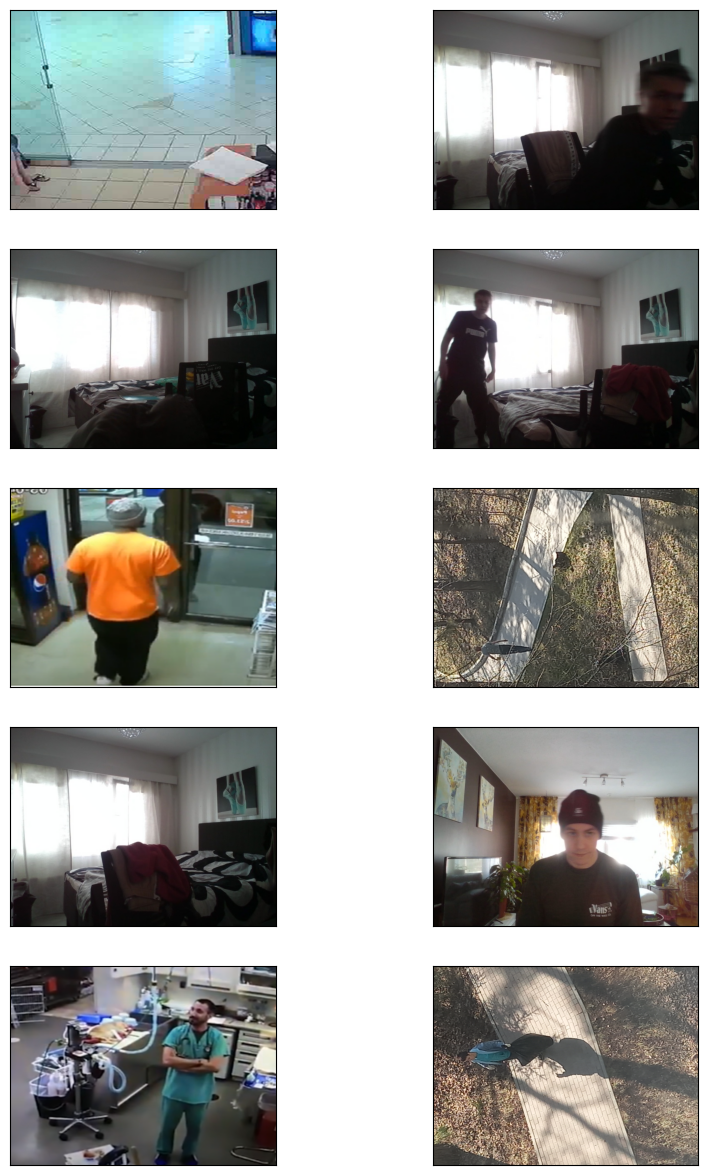

In [7]:
# Plot sample images
fig, axs = plt.subplots(5, 2, figsize=(10, 15))
for i, img_path in enumerate(plot_images):
    img = mpimg.imread(os.path.join(IMAGES_DIR, img_path))
    axs[i // 2, i % 2].imshow(img)
    axs[i // 2, i % 2].set_xticks([])
    axs[i // 2, i % 2].set_yticks([])
plt.show()

In [8]:
# Configure settings for the augmentations pipeline
transform = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.3),
    alb.RandomGamma(p=0.3),
    alb.RGBShift(p=0.3)
], bbox_params=alb.BboxParams(
    format='albumentations',
    min_area=0.15, # Remove bounding box if too small after cropping
    label_fields=['class_labels'])
)

In [9]:
def augment_image(transformer, amount, filename):
    img = cv2.imread(os.path.join(IMAGES_DIR, filename))
    label_path = os.path.join(LABELS_DIR, f'{Path(filename).stem}.json')
    height, width = img.shape[0], img.shape[1]

    # For Albumentations - xmax and ymax must be larger than xmin and ymin to augment the image
    bboxes = [0, 0, 0.000001, 0.000001]
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label = json.load(f)
        for shape in label['shapes']:
            # Get bounding boxes coordinates and store them into array for Albumentations
            # Sort coordinates if in wrong order. If bounding boxes are drawn in different order inside labelme,
            #(for example, top to bottom vs bottom to top) the coordinates can be ordered differently.
            (xmin, ymin), (xmax, ymax) = shape['points']
            xmin, xmax = sorted([xmin, xmax])
            ymin, ymax = sorted([ymin, ymax])
            bboxes = [xmin, ymin, xmax, ymax]
            # Convert coordinates to albumentations format
            # Normalize by dividing x coordinates with width of the image and y with height
            bboxes = list(np.divide(bboxes, [width, height, width, height]))

    try:
        # Create new directories for storing the augmented images and labels
        aug_image_dir = os.path.join('..', 'augmented_data', 'images')
        aug_label_dir = os.path.join('..', 'augmented_data', 'labels')
        if not os.path.exists(aug_image_dir):
            os.makedirs(aug_image_dir)
        if not os.path.exists(aug_label_dir):
            os.makedirs(aug_label_dir)
        
        for x in range(amount):
            # Augment and then store the images
            transformed = transformer(image=img, bboxes=[bboxes], class_labels=['notbuddy'])
            cv2.imwrite(os.path.join(aug_image_dir, f'{Path(filename).stem}.{x}.png'), transformed['image'])

            annotation = {}
            annotation['image'] = filename
            annotation['class'] = []

            if os.path.exists(label_path):
                if len(transformed['bboxes']) == 0:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'].append(0)
                else:
                    annotation['bbox'] = transformed['bboxes'][0]
                    if transformed['class_labels'][0] == 'notbuddy':
                        annotation['class'].append(1)
                            
            # No label json file = no bouding boxes in this image
            else: 
                annotation['bbox'] = [0, 0, 0, 0]
                annotation['class'].append(0)
            
            with open(os.path.join(aug_label_dir, f'{Path(filename).stem}.{x}.json'), 'w') as f:
                json.dump(annotation, f)
                
    except Exception as e:
        print(e)

Images with bounding box: 820
Images without bounding box: 140


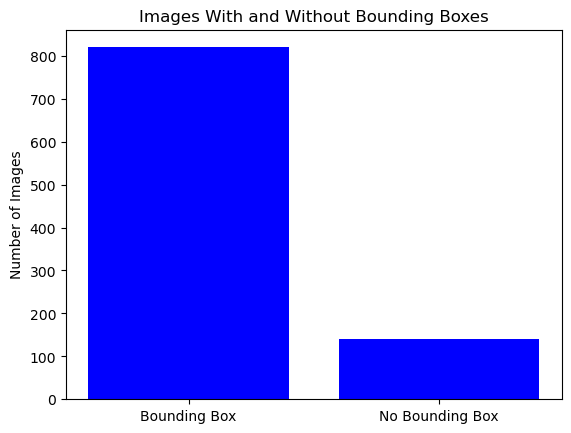

In [11]:
images_class = []
images_no_class = []

for image in images:
    json_file = os.path.join(LABELS_DIR, f'{Path(image).stem}.json')

    if os.path.isfile(json_file):
        images_class.append(image)
    else:
        images_no_class.append(image)

amount_class = len(images_class)
amount_no_class = len(images_no_class)

print(f'Images with bounding box: {amount_class}')
print(f'Images without bounding box: {amount_no_class}')

categories = ['Bounding Box', 'No Bounding Box']
file_counts = [amount_class, amount_no_class]

plt.bar(categories, file_counts, color='blue')
plt.ylabel('Number of Images')
plt.title('Images With and Without Bounding Boxes')

plt.show()

In [12]:
# Augment images with bounding box
for image in images_class:
    augment_image(transform, 50, image)
print('Bounding box images succesfully augmented')

Bounding box images succesfully augmented


In [13]:
# Augment images without bounding box
for image in images_no_class:
    augment_image(transform, 30, image)
print('Bounding boxless images succesfully augmented')

Bounding boxless images succesfully augmented


In [14]:
AUG_DATA_DIR = os.path.join('..', 'augmented_data')

aug_images = glob.glob(os.path.join(AUG_DATA_DIR, 'images', '*.png'))
aug_labels = glob.glob(os.path.join(AUG_DATA_DIR, 'labels', '*.json'))

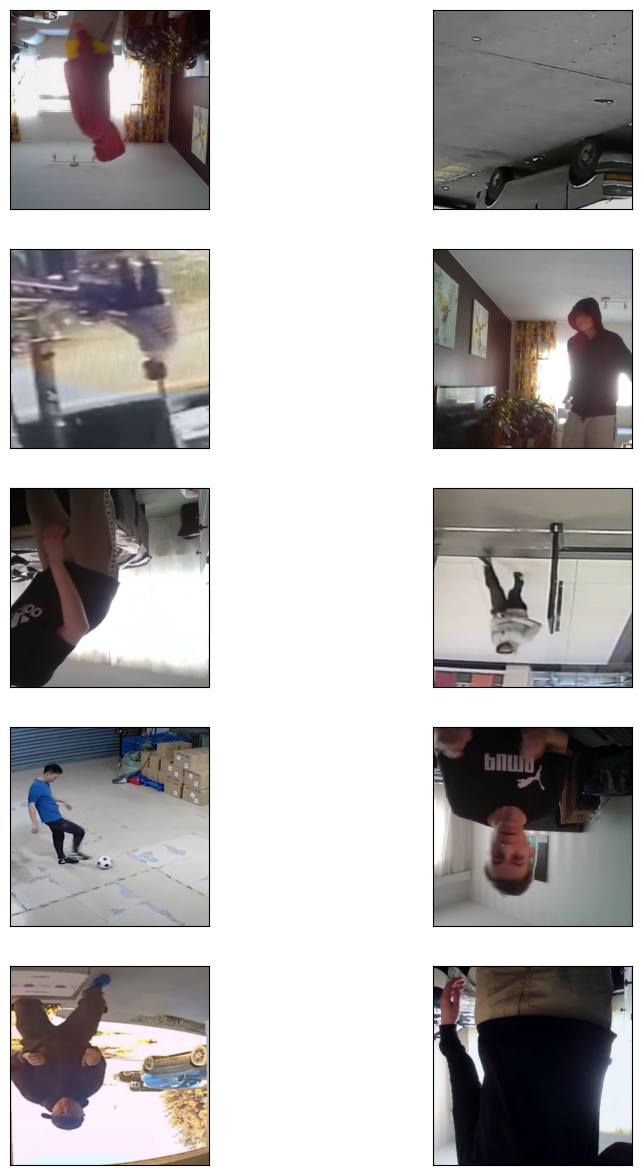

In [15]:
# Plot sample images from the augmented data
plot_images = random.sample(aug_images, 10)

fig, axs = plt.subplots(5, 2, figsize=(10, 15))
for i, img_path in enumerate(plot_images):
    img = mpimg.imread(img_path)
    axs[i // 2, i % 2].imshow(img)
    axs[i // 2, i % 2].set_xticks([])
    axs[i // 2, i % 2].set_yticks([])
    
plt.show()

There are 39742 augmented images with a bounding box
There are 5458 augmented images with no bounding box in them


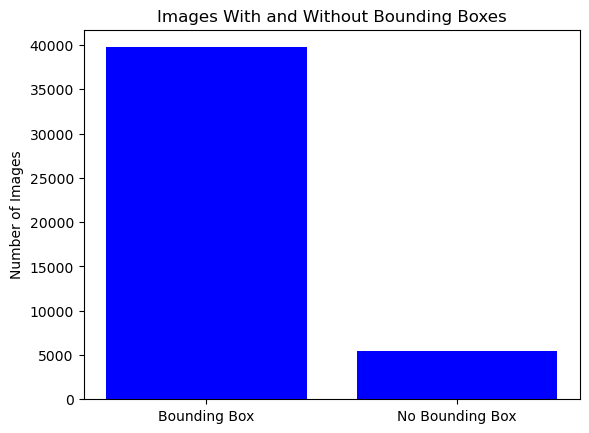

In [17]:
notbuddy_labels = 0
zero_labels = 0

for aug_label_path in aug_labels:
    with open(aug_label_path, 'r', encoding = "utf-8") as f:
        label = json.load(f)
        if label['class'] == [1]:
            notbuddy_labels += 1
        elif label['class'] == [0]:
            zero_labels += 1

print(f'There are {notbuddy_labels} augmented images with a bounding box')
print(f'There are {zero_labels} augmented images with no bounding box in them')

categories = ['Bounding Box', 'No Bounding Box']
file_counts = [notbuddy_labels, zero_labels]

plt.bar(categories, file_counts, color='blue')
plt.ylabel('Number of Images')
plt.title('Images With and Without Bounding Boxes')

plt.show()